# Decision Tree Model with One Hot Encoder for Categorical Variables

- Clean code version

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import pandas
import numpy
import itertools
import matplotlib.pyplot as plt
import sklearn
from sklearn import tree
from sklearn.metrics import log_loss
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import CategoricalNB

In [3]:
import loan_approval_lib
from loan_approval_lib import logspace, linspace

In [4]:
data = loan_approval_lib.load_original_data()

In [5]:
data

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,0.59,Y,3,1
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0.10,N,2,0
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,N,3,1
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,0.53,N,2,1
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,Y,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0.11,N,30,0
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0.15,N,19,0
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,0.46,N,28,1
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0.10,N,26,0


In [6]:
data_train = loan_approval_lib.load_data_train()

In [7]:
data_test = loan_approval_lib.load_data_test()

# Data Cleaning

In [8]:
def data_cleaning_algorithm(data):
    columns = [
        'person_age',
        'person_income',
        'person_emp_length',
        'loan_amnt',
        'loan_int_rate',
        'loan_percent_income',
        'cb_person_default_on_file'
    ]
    
    for column in columns:
        row_count_1 = len(data)
    
        if column == 'person_age':
            data = data[data['person_age'] <= 100]
    
        if column == 'person_emp_length':
            data = data[data['person_emp_length'] <= 100]
    
        data = data[data[column].isna() == False]
        
        row_count_2 = len(data)
        row_count_diff = row_count_1 - row_count_2
        print(f'column {column}, number of removed rows: {row_count_diff}')

    return data
    

In [9]:
data = data_cleaning_algorithm(data)

column person_age, number of removed rows: 5
column person_income, number of removed rows: 0
column person_emp_length, number of removed rows: 897
column loan_amnt, number of removed rows: 0
column loan_int_rate, number of removed rows: 3047
column loan_percent_income, number of removed rows: 0
column cb_person_default_on_file, number of removed rows: 0


# Loan Grade

In [13]:
def create_loan_grade_numerical_from_loan_grade(data):
    loan_grades = list(sorted(data['loan_grade'].unique()))
    
    for loan_grade in loan_grades:
        data.loc[data['loan_grade'] == loan_grade, 'loan_grade_numerical'] = ord(loan_grade) - ord('A')
    
        data_train.loc[data_train['loan_grade'] == loan_grade, 'loan_grade_numerical'] = ord(loan_grade) - ord('A')
        
        data_test.loc[data_test['loan_grade'] == loan_grade, 'loan_grade_numerical'] = ord(loan_grade) - ord('A')

In [14]:
create_loan_grade_numerical_from_loan_grade(data)

In [15]:
data

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,loan_grade_numerical
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0.10,N,2,0,1.0
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,N,3,1,2.0
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,0.53,N,2,1,2.0
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,Y,4,1,2.0
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,0.25,N,2,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0.11,N,30,0,2.0
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0.15,N,19,0,0.0
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,0.46,N,28,1,1.0
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0.10,N,26,0,1.0


# Person Home Ownership

In [18]:
def create_person_home_ownership_one_hot_encoder(data):
    encoder = OneHotEncoder(sparse_output=False)
    encoder.fit(data[['person_home_ownership']])
    return encoder

In [19]:
def create_person_home_ownership_one_hot(encoder, data):
    transformed = encoder.transform(data[['person_home_ownership']])
    
    data = pandas.concat(
        [
            data,
            pandas.DataFrame(
                transformed,
                index=data.index,
                columns=encoder.get_feature_names_out(['person_home_ownership']),
            ),
        ],
        axis=1,
    )
    return data

In [20]:
encoder = create_person_home_ownership_one_hot_encoder(data)

data = create_person_home_ownership_one_hot(encoder, data)
data_train = create_person_home_ownership_one_hot(encoder, data_train)
data_test = create_person_home_ownership_one_hot(encoder, data_test)

# Loan Intent

In [21]:
def create_loan_intent_one_hot_encoder(data):
    encoder = OneHotEncoder(sparse_output=False)
    encoder.fit(data[['loan_intent']])
    return encoder

In [26]:
def create_loan_intent_one_hot(encoder, data):
    transformed = encoder.transform(data[['loan_intent']])
    
    data = pandas.concat(
        [
            data,
            pandas.DataFrame(
                transformed,
                index=data.index,
                #columns = [f'person_home_ownership_{category}' for category in encoder.categories_],
                columns=encoder.get_feature_names_out(['loan_intent']),
            ),
        ],
        axis=1,
    )
    return data

In [27]:
encoder = create_loan_intent_one_hot_encoder(data)

data = create_loan_intent_one_hot(encoder, data)
data_train = create_loan_intent_one_hot(encoder, data_train)
data_test = create_loan_intent_one_hot(encoder, data_test)

# Default on File

In [28]:
def map_cb_person_default_on_file(data):
    data['cb_person_default_on_file'] = data['cb_person_default_on_file'].map(lambda x: 1 if x == 'Y' else 0)
    return data

In [29]:
data = map_cb_person_default_on_file(data)
data_train = map_cb_person_default_on_file(data_train)
data_test = map_cb_person_default_on_file(data_test)

# Choose Columns for Tree Model

In [30]:
for column in data.columns:
    print(column)

person_age
person_income
person_home_ownership
person_emp_length
loan_intent
loan_grade
loan_amnt
loan_int_rate
loan_percent_income
cb_person_default_on_file
cb_person_cred_hist_length
loan_status
loan_grade_numerical
person_home_ownership_MORTGAGE
person_home_ownership_OTHER
person_home_ownership_OWN
person_home_ownership_RENT
loan_intent_DEBTCONSOLIDATION
loan_intent_EDUCATION
loan_intent_HOMEIMPROVEMENT
loan_intent_MEDICAL
loan_intent_PERSONAL
loan_intent_VENTURE


In [31]:
def create_decision_tree_columns():
    decision_tree_columns = [
        'person_age',
        'person_income',
        'person_emp_length',
        'loan_amnt',
        'loan_int_rate',
        'loan_percent_income',
        'cb_person_cred_hist_length',
        'loan_grade_numerical',
        'person_home_ownership_MORTGAGE',
        'person_home_ownership_OTHER',
        'person_home_ownership_OWN',
        'person_home_ownership_RENT',
        'loan_intent_DEBTCONSOLIDATION',
        'loan_intent_EDUCATION',
        'loan_intent_HOMEIMPROVEMENT',
        'loan_intent_MEDICAL',
        'loan_intent_PERSONAL',
        'loan_intent_VENTURE',
        'cb_person_default_on_file',
    ]
    return decision_tree_columns

In [32]:
def create_decision_tree_columns_with_id():
    decision_tree_columns = create_decision_tree_columns()
    
    decision_tree_columns_with_id = [
        column for column in decision_tree_columns
    ]
    decision_tree_columns_with_id.append('id')
    
    return decision_tree_columns_with_id

In [33]:
decision_tree_columns = create_decision_tree_columns()
decision_tree_columns_with_id = create_decision_tree_columns_with_id()

In [26]:
for column in data.columns:
    if not column in decision_tree_columns:
        print(f'column {column} is excluded from the model')

column person_home_ownership is excluded from the model
column loan_intent is excluded from the model
column loan_grade is excluded from the model
column loan_status is excluded from the model
column cb_person_default_on_file_vote is excluded from the model
column cb_person_default_on_file_predict is excluded from the model


# Copy DataFrame and drop unused columns

In [37]:
def create_dataframe_copy_and_drop_columns(data):
    data_copy = data.copy()

    data_copy.drop(
        columns=[
            'person_home_ownership',
            'loan_intent',
            'loan_grade',
        ],
        inplace=True,
    )
    
    return data_copy

In [38]:
data_copy = create_dataframe_copy_and_drop_columns(data)
data_train_copy = create_dataframe_copy_and_drop_columns(data_train)
data_test_copy = create_dataframe_copy_and_drop_columns(data_test)

In [39]:
for column in data_copy.columns:
    print(column)

person_age
person_income
person_emp_length
loan_amnt
loan_int_rate
loan_percent_income
cb_person_default_on_file
cb_person_cred_hist_length
loan_status
loan_grade_numerical
person_home_ownership_MORTGAGE
person_home_ownership_OTHER
person_home_ownership_OWN
person_home_ownership_RENT
loan_intent_DEBTCONSOLIDATION
loan_intent_EDUCATION
loan_intent_HOMEIMPROVEMENT
loan_intent_MEDICAL
loan_intent_PERSONAL
loan_intent_VENTURE


# Split data into test and training datasets

In [63]:
data_copy_train = data_copy.iloc[0:18000].copy()

In [64]:
data_copy_test = data_copy.iloc[18000:].copy()

In [38]:
X = data_copy_train[decision_tree_columns].copy()
Y = data_copy_train['loan_status'].copy()

In [39]:
X_test = data_copy_test[decision_tree_columns].copy()

# Decision Tree Model

In [115]:
def decision_tree_model_train(
    data_train,
    decision_tree_columns,
    max_depth,
    min_samples_split,
    min_samples_leaf,
):
    
    X = data_train[decision_tree_columns].copy()
    Y = data_train['loan_status'].copy()
    
    clf = tree.DecisionTreeClassifier(
        criterion='entropy',
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
    )
    clf = clf.fit(X, Y)

    feature_importances = pandas.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
    feature_importances = feature_importances[feature_importances > 0]

    Z = clf.predict(X)
    X['loan_status_predict'] = Z
    X['loan_status'] = data_train['loan_status']
    accuracy_in_sample = (X['loan_status'] == X['loan_status_predict']).sum() / len(X)

    return (clf, feature_importances, accuracy_in_sample)

In [53]:
def decision_tree_model_test(
    clf,
    data_test,
    decision_tree_columns,
):

    X_test = data_test[decision_tree_columns].copy()
    
    Z_test = clf.predict(X_test)
    X_test['loan_status_predict'] = Z_test
    X_test['loan_status'] = data_test['loan_status']
    accuracy_out_of_sample = (X_test['loan_status'] == X_test['loan_status_predict']).sum() / len(X_test)
    
    return accuracy_out_of_sample

In [54]:
def decision_tree_model_predict(
    clf,
    data_predict,
    decision_tree_columns,
    decision_tree_columns_with_id,
):
    
    X_predict = data_predict[decision_tree_columns_with_id].copy()

    Z_predict = clf.predict_proba(X_predict[decision_tree_columns])
    X_predict['loan_status'] = Z_predict[:, 1]

    return X_predict

In [55]:
def decision_tree_model_predict_write_to_csv(
    data_predict,
    filename,
):
    data_predict[['id', 'loan_status']].to_csv(filename, index=False)

In [56]:
# Usage

(
    clf,
    feature_importances,
    accuracy_in_sample,
) = decision_tree_model_train(
    data_copy,
    decision_tree_columns,
    15,
)

accuracy_out_of_sample = decision_tree_model_test(
    clf,
    data_train_copy,
    decision_tree_columns,
)

data_predict = decision_tree_model_predict(
    clf,
    data_test_copy,
    decision_tree_columns,
    decision_tree_columns_with_id,
)

decision_tree_model_predict_write_to_csv(
    data_predict,
    f'decision_tree_model_example_usage.csv'
)

In [57]:
accuracy_in_sample

np.float64(0.954491478066499)

In [58]:
accuracy_out_of_sample

np.float64(0.9434222866399522)

In [59]:
feature_importances

loan_percent_income               0.224110
loan_grade_numerical              0.212534
person_home_ownership_RENT        0.156097
person_income                     0.139044
person_emp_length                 0.047394
loan_int_rate                     0.038933
person_home_ownership_OWN         0.029220
loan_intent_MEDICAL               0.027988
person_age                        0.026997
loan_intent_DEBTCONSOLIDATION     0.024540
loan_amnt                         0.018965
loan_intent_HOMEIMPROVEMENT       0.013581
loan_intent_VENTURE               0.012297
cb_person_cred_hist_length        0.012128
person_home_ownership_MORTGAGE    0.009880
loan_intent_EDUCATION             0.002903
loan_intent_PERSONAL              0.002733
cb_person_default_on_file         0.000655
dtype: float64

In [ ]:
# for reference only / documentation (do not run or call this)
def run_decision_tree_model_with_max_depth(data_copy_train, data_copy_test, decision_tree_columns, max_depth):

    X = data_copy_train[decision_tree_columns].copy()
    Y = data_copy_train['loan_status'].copy()

    X_test = data_copy_test[decision_tree_columns].copy()
    
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf = clf.fit(X, Y)

    Z = clf.predict(X)
    data_copy_train['loan_status_tree_predict'] = Z
    accuracy_in_sample = (data_copy_train['loan_status'] == data_copy_train['loan_status_tree_predict']).sum() / len(data_copy_train)

    feature_importances = pandas.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
    feature_importances = feature_importances[feature_importances > 0]

    Z_test = clf.predict(X_test)
    data_copy_test['loan_status_tree_predict'] = Z_test
    accuracy_out_of_sample = (data_copy_test['loan_status'] == data_copy_test['loan_status_tree_predict']).sum() / len(data_copy_test)

    return (accuracy_in_sample, accuracy_out_of_sample, feature_importances)

# Decision Tree Model - Max Depth 1

In [65]:
(
    clf,
    feature_importances,
    accuracy_in_sample,
) = decision_tree_model_train(
    data_copy_train, #data_copy,
    decision_tree_columns,
    1,
)

accuracy_out_of_sample = decision_tree_model_test(
    clf,
    data_copy_test, #data_train_copy,
    decision_tree_columns,
)

# data_predict = decision_tree_model_predict(
#     clf,
#     data_test_copy,
#     decision_tree_columns,
#     decision_tree_columns_with_id,
# )

# decision_tree_model_predict_write_to_csv(
#     data_predict,
#     f'decision_tree_model_one_hot_2_clean_code_maxdepth_1.csv'
# )

In [66]:
feature_importances

loan_percent_income    1.0
dtype: float64

In [67]:
accuracy_in_sample

np.float64(0.8240555555555555)

In [68]:
accuracy_out_of_sample

np.float64(0.844714070729872)

# Decision Tree Model - Max Depth 2

In [69]:
(
    clf,
    feature_importances,
    accuracy_in_sample,
) = decision_tree_model_train(
    data_copy_train, #data_copy,
    decision_tree_columns,
    2,
)

accuracy_out_of_sample = decision_tree_model_test(
    clf,
    data_copy_test, #data_train_copy,
    decision_tree_columns,
)

In [70]:
accuracy_in_sample

np.float64(0.8712777777777778)

In [74]:
accuracy_out_of_sample

np.float64(0.875)

In [73]:
feature_importances

loan_percent_income           0.396194
loan_grade_numerical          0.369497
person_home_ownership_RENT    0.234308
dtype: float64

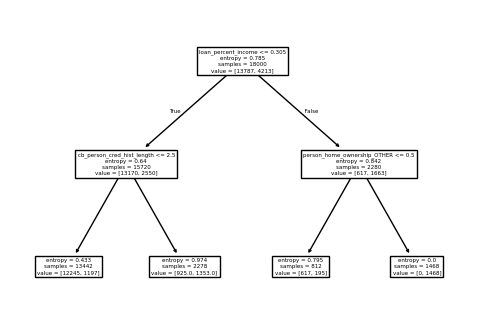

In [72]:
width = 6
height = 4
plt.figure(figsize=(width, height))

tree.plot_tree(clf, feature_names=data_copy_train.columns)

plt.savefig('decision_tree_model_one_hot_2_clean_code_maxdepth_2_tree.pdf')
plt.savefig('decision_tree_model_one_hot_2_clean_code_maxdepth_2_tree.png')
plt.show()

# Decision Tree Model - Max Depth 3

In [78]:
(
    clf,
    feature_importances,
    accuracy_in_sample,
) = decision_tree_model_train(
    data_copy_train, #data_copy,
    decision_tree_columns,
    3,
)

accuracy_out_of_sample = decision_tree_model_test(
    clf,
    data_copy_test, #data_train_copy,
    decision_tree_columns,
)

In [79]:
accuracy_in_sample

np.float64(0.881)

In [80]:
accuracy_out_of_sample

np.float64(0.8792325056433409)

In [81]:
feature_importances

loan_percent_income              0.341362
loan_grade_numerical             0.318360
person_home_ownership_RENT       0.201881
person_income                    0.107289
loan_intent_DEBTCONSOLIDATION    0.031108
dtype: float64

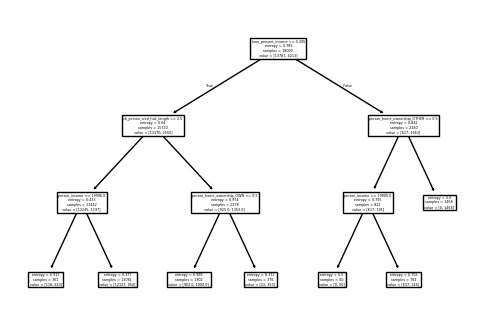

In [83]:
width = 6
height = 4
plt.figure(figsize=(width, height))

tree.plot_tree(clf, feature_names=data_copy_train.columns)

plt.savefig('decision_tree_model_one_hot_2_clean_code_maxdepth_3_tree.pdf')
plt.savefig('decision_tree_model_one_hot_2_clean_code_maxdepth_3_tree.png')
plt.show()

# Decision Tree Model - Max Depth 4

In [84]:
(
    clf,
    feature_importances,
    accuracy_in_sample,
) = decision_tree_model_train(
    data_copy_train, #data_copy,
    decision_tree_columns,
    4,
)

accuracy_out_of_sample = decision_tree_model_test(
    clf,
    data_copy_test, #data_train_copy,
    decision_tree_columns,
)

In [85]:
accuracy_in_sample

np.float64(0.8999444444444444)

In [86]:
accuracy_out_of_sample

np.float64(0.9077313769751693)

In [87]:
feature_importances

loan_percent_income              0.338336
loan_grade_numerical             0.292248
person_home_ownership_RENT       0.179540
person_income                    0.113461
loan_intent_MEDICAL              0.033467
loan_intent_DEBTCONSOLIDATION    0.027666
person_home_ownership_OWN        0.015284
dtype: float64

# Decision Tree Model - Max Depth 5

In [88]:
(
    clf,
    feature_importances,
    accuracy_in_sample,
) = decision_tree_model_train(
    data_copy_train, #data_copy,
    decision_tree_columns,
    5,
)

accuracy_out_of_sample = decision_tree_model_test(
    clf,
    data_copy_test, #data_train_copy,
    decision_tree_columns,
)

In [89]:
accuracy_in_sample

np.float64(0.9181666666666667)

In [90]:
accuracy_out_of_sample

np.float64(0.9193002257336343)

In [91]:
feature_importances

loan_percent_income               0.313706
loan_grade_numerical              0.273107
person_home_ownership_RENT        0.167636
person_income                     0.105201
person_emp_length                 0.039473
loan_intent_MEDICAL               0.031031
loan_intent_DEBTCONSOLIDATION     0.027868
person_home_ownership_OWN         0.016820
loan_intent_HOMEIMPROVEMENT       0.012631
loan_int_rate                     0.009880
person_home_ownership_MORTGAGE    0.002646
dtype: float64

## Make prediction for Kaggle Competition Test dataset

### Max depth 5

In [92]:
data_predict = decision_tree_model_predict(
    clf,
    data_test_copy,
    decision_tree_columns,
    decision_tree_columns_with_id,
)

decision_tree_model_predict_write_to_csv(
    data_predict,
    f'decision_tree_model_one_hot_2_clean_code_maxdepth_5.csv'
)

### No max depth

In [93]:
(
    clf,
    feature_importances,
    accuracy_in_sample,
) = decision_tree_model_train(
    data_copy_train, #data_copy,
    decision_tree_columns,
    None,
)

accuracy_out_of_sample = decision_tree_model_test(
    clf,
    data_copy_test, #data_train_copy,
    decision_tree_columns,
)

In [94]:
accuracy_in_sample

np.float64(1.0)

In [95]:
accuracy_out_of_sample

np.float64(0.8880737396538751)

In [96]:
feature_importances

loan_percent_income               0.208249
loan_grade_numerical              0.160086
person_income                     0.158365
person_home_ownership_RENT        0.126135
loan_int_rate                     0.070390
person_emp_length                 0.053739
loan_amnt                         0.046531
person_age                        0.046121
loan_intent_MEDICAL               0.022020
cb_person_cred_hist_length        0.021500
loan_intent_DEBTCONSOLIDATION     0.019963
person_home_ownership_OWN         0.018325
loan_intent_HOMEIMPROVEMENT       0.015124
loan_intent_VENTURE               0.010269
loan_intent_EDUCATION             0.006740
loan_intent_PERSONAL              0.006568
person_home_ownership_MORTGAGE    0.006060
cb_person_default_on_file         0.003088
person_home_ownership_OTHER       0.000728
dtype: float64

In [97]:
data_predict = decision_tree_model_predict(
    clf,
    data_test_copy,
    decision_tree_columns,
    decision_tree_columns_with_id,
)

decision_tree_model_predict_write_to_csv(
    data_predict,
    f'decision_tree_model_one_hot_2_clean_code_maxdepth_None.csv'
)

# Decision Tree Model - Max Depth 6

### Original dataset

- Use training portion of original dataset for training
- Use testing portion of original dataset for testing

In [98]:
(
    clf,
    feature_importances,
    accuracy_in_sample,
) = decision_tree_model_train(
    data_copy_train, #data_copy,
    decision_tree_columns,
    6,
)

accuracy_out_of_sample = decision_tree_model_test(
    clf,
    data_copy_test, #data_train_copy,
    decision_tree_columns,
)

In [99]:
accuracy_in_sample

np.float64(0.9272777777777778)

In [100]:
accuracy_out_of_sample

np.float64(0.9294582392776524)

In [101]:
feature_importances

loan_percent_income               0.289242
loan_grade_numerical              0.251810
person_home_ownership_RENT        0.206551
person_income                     0.102668
person_emp_length                 0.036395
person_home_ownership_OWN         0.029262
loan_intent_MEDICAL               0.028611
loan_intent_DEBTCONSOLIDATION     0.025695
loan_intent_HOMEIMPROVEMENT       0.012539
loan_int_rate                     0.009110
loan_intent_VENTURE               0.004524
person_home_ownership_MORTGAGE    0.002440
cb_person_cred_hist_length        0.001154
dtype: float64

### Original dataset for training, Kaggle competition dataset for testing

- Use training portion of original dataset for training
- Use Kaggle competition training dataset for testing

In [102]:
(
    clf,
    feature_importances,
    accuracy_in_sample,
) = decision_tree_model_train(
    data_copy_train, #data_copy,
    decision_tree_columns,
    6,
)

accuracy_out_of_sample = decision_tree_model_test(
    clf,
    data_train_copy, #data_train_copy,
    decision_tree_columns,
)

In [103]:
accuracy_in_sample

np.float64(0.9272777777777778)

In [104]:
accuracy_out_of_sample

np.float64(0.9494415551197886)

In [105]:
feature_importances

loan_percent_income               0.289242
loan_grade_numerical              0.251810
person_home_ownership_RENT        0.206551
person_income                     0.102668
person_emp_length                 0.036395
person_home_ownership_OWN         0.029262
loan_intent_MEDICAL               0.028611
loan_intent_DEBTCONSOLIDATION     0.025695
loan_intent_HOMEIMPROVEMENT       0.012539
loan_int_rate                     0.009110
loan_intent_VENTURE               0.004524
person_home_ownership_MORTGAGE    0.002440
cb_person_cred_hist_length        0.001154
dtype: float64

### Original dataset for training, Kaggle competition test dataset for submission creation

- Use training portion of original dataset for training
- Use Kaggle competition test dataset for prediction

In [108]:
(
    clf,
    feature_importances,
    accuracy_in_sample,
) = decision_tree_model_train(
    data_copy_train, #data_copy,
    decision_tree_columns,
    6,
)

In [109]:
accuracy_in_sample

np.float64(0.9272777777777778)

In [110]:
feature_importances

loan_percent_income               0.289242
loan_grade_numerical              0.251810
person_home_ownership_RENT        0.206551
person_income                     0.102668
person_emp_length                 0.036395
person_home_ownership_OWN         0.029262
loan_intent_MEDICAL               0.028611
loan_intent_DEBTCONSOLIDATION     0.025695
loan_intent_HOMEIMPROVEMENT       0.012539
loan_int_rate                     0.009110
loan_intent_VENTURE               0.004524
person_home_ownership_MORTGAGE    0.002440
cb_person_cred_hist_length        0.001154
dtype: float64

In [107]:
data_predict = decision_tree_model_predict(
    clf,
    data_test_copy,
    decision_tree_columns,
    decision_tree_columns_with_id,
)

decision_tree_model_predict_write_to_csv(
    data_predict,
    f'decision_tree_model_one_hot_2_clean_code_maxdepth_6.csv'
)

### Repeat of above, but use full length dataset for training

- Use entire original dataset for training
- Use Kaggle competition test dataset for prediction

In [112]:
(
    clf,
    feature_importances,
    accuracy_in_sample,
) = decision_tree_model_train(
    data_copy,
    decision_tree_columns,
    6,
)

In [114]:
data_predict = decision_tree_model_predict(
    clf,
    data_test_copy,
    decision_tree_columns,
    decision_tree_columns_with_id,
)

decision_tree_model_predict_write_to_csv(
    data_predict,
    f'decision_tree_model_one_hot_2_clean_code_maxdepth_6_full_training_dataset.csv'
)

# Decision Tree Model with more detailed regularization

In [132]:
(
    clf,
    feature_importances,
    accuracy_in_sample,
) = decision_tree_model_train(
    data_copy,
    decision_tree_columns,
    None,
    30,
    4,
)

accuracy_out_of_sample = decision_tree_model_test(
    clf,
    data_train_copy,
    decision_tree_columns,
)

In [133]:
accuracy_in_sample

np.float64(0.9453059513830679)

In [134]:
accuracy_out_of_sample

np.float64(0.9427402165572513)

In [135]:
data_predict = decision_tree_model_predict(
    clf,
    data_test_copy,
    decision_tree_columns,
    decision_tree_columns_with_id,
)

decision_tree_model_predict_write_to_csv(
    data_predict,
    f'decision_tree_model_one_hot_2_clean_code_maxdepth_None_minsamplesplit_30_minsamplenode_4_full_training_dataset.csv'
)

In [131]:
(
    clf,
    feature_importances,
    accuracy_in_sample,
) = decision_tree_model_train(
    data_copy,
    decision_tree_columns,
    None,
    2,
    10,
)

accuracy_out_of_sample = decision_tree_model_test(
    clf,
    data_train_copy,
    decision_tree_columns,
)

(accuracy_in_sample, accuracy_out_of_sample)

(np.float64(0.9429309863090248), np.float64(0.9386989513172479))